In [1]:
import os
import sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PROJECT_ROOT)

from trial_class import *
from experiment_class import Experiment

import numpy as np
import pandas as pd
import tdt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from scipy.signal import butter, filtfilt
from sklearn.linear_model import LinearRegression
from sp_extension import *

In [2]:
experiment_path = r"/Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/C1_2_3_Social_Pref/all"
csv_base_path = r"/Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/C1_2_3_Social_Pref/all_csvs"
brain_region = '#15616F'

# NAc: #15616F
# mPFC: #FFAF00

In [3]:
# groups csv + experiment data into one variable
experiment = Experiment(experiment_path, csv_base_path)

# batch process the data, removing the specified time segments for subjects
experiment.default_batch_process()

Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/C1_2_3_Social_Pref/all/p5-240826-091418/Notes.txt
read from t=0s to t=790.95s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/C1_2_3_Social_Pref/all/nn2-250117-085631/Notes.txt
read from t=0s to t=814.05s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/C1_2_3_Social_Pref/all/p2-240523-081105/Notes.txt
read from t=0s to t=788.65s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/C1_2_3_Social_Pref/all/nn4-250118-094351/Notes.txt
read from t=0s to t=795.95s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/C1_2_3_Social_Pref/all/n6-240826-094701/Notes.txt
read from t=0s to t=800.05s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/C1_2_3_Social_Pref/all/nn1-25011

In [4]:
bout_definitions = [
    {'prefix': 'Subject', 'introduced': 'Subject Introduced', 'removed': 'Subject Removed'}
]

experiment.group_extract_manual_annotations(bout_definitions)

Processing behaviors for p5-240826-091418...
Processing behaviors for nn2-250117-085631...
Processing behaviors for p2-240523-081105...
Processing behaviors for nn4-250118-094351...
Processing behaviors for n6-240826-094701...
Processing behaviors for nn1-250117-081652...
Processing behaviors for pp7-250118-075659...
Processing behaviors for pp3-250118-064713...
Processing behaviors for p8-240827-075823...
Processing behaviors for nn8-250118-105443...
Processing behaviors for n3-240523-073132...
Processing behaviors for p1-240522-080200...
Processing behaviors for n5-240826-083822...
Processing behaviors for n4-240523-084829...
Processing behaviors for p6-240827-065303...
Processing behaviors for pp5-250117-121543...
Processing behaviors for pp4-250118-072201...
Processing behaviors for nn7-250118-101917...
Processing behaviors for pp8-250118-083250...
Processing behaviors for nn6-250117-101903...
Processing behaviors for p7-240826-102402...
Processing behaviors for pp6-250117-124823..

## Long-Term Bar Graph - Total Investigation Time

In [13]:
import os
import pandas as pd

def fix_behavior_data_for_experiment(experiment, csv_base_path):
    """
    Loads and converts raw CSVs into behavior DataFrames for each trial in the experiment.
    Replaces experiment.trials[trial_name].behaviors with the corrected DataFrame.
    """
    fixed_trials = 0
    skipped_trials = 0

    for trial_name in experiment.trials:
        csv_file = os.path.join(csv_base_path, trial_name + ".csv")

        if not os.path.exists(csv_file):
            print(f"CSV not found for trial '{trial_name}' — skipped.")
            skipped_trials += 1
            continue

        try:
            raw_df = pd.read_csv(csv_file)

            # Only process rows that have Start, Stop, Duration
            if {"Start (s)", "Stop (s)", "Duration (s)", "Behavior"}.issubset(raw_df.columns):
                behavior_df = pd.DataFrame({
                    "Behavior": raw_df["Behavior"],
                    "Event_Start": raw_df["Start (s)"],
                    "Event_End": raw_df["Stop (s)"],
                    "Duration (s)": raw_df["Duration (s)"],
                    "Bout": raw_df.get("Subject", "Subject-1")  # fallback if no 'Subject'
                })

                # Clean up NaNs, e.g., missing durations
                behavior_df.dropna(subset=["Event_Start", "Event_End", "Duration (s)"], inplace=True)

                # Inject into experiment object
                experiment.trials[trial_name].behaviors = behavior_df.reset_index(drop=True)
                fixed_trials += 1
            else:
                print(f"CSV for trial '{trial_name}' missing required columns — skipped.")
                skipped_trials += 1

        except Exception as e:
            print(f"Error processing trial '{trial_name}': {e}")
            skipped_trials += 1

    print(f"\nFinished processing CSVs.")
    print(f"Fixed trials: {fixed_trials}")
    print(f"Skipped trials: {skipped_trials}")

In [ ]:
def plot_custom_sniff_cup_assignments(experiment, bar_color='#cccccc', figsize=(6, 8)):
    """
    For each subject, extracts total investigation time for a pre-assigned 'sniff cup X' behavior,
    and plots the mean + individual data points.
    """

    # --- Hardcoded sniff cup assignments ---
    subject_to_behavior = {
        "N1": "sniff cup 3",
        "P1": "sniff cup 4",
        "N2": "sniff cup 1",
        "P3": "sniff cup 2",
        "N3": "sniff cup 2",
        "P2": "sniff cup 1",
        "N4": "sniff cup 4",
        "P4": "sniff cup 3",
        "N5": "sniff cup 3",
        "P5": "sniff cup 4",
        "N6": "sniff cup 1",
        "P7": "sniff cup 2",
        "P6": "sniff cup 1",
        "N7": "sniff cup 2",
        "P8": "sniff cup 3",
        "Nn1": "sniff cup 4",
        "Nn2": "sniff cup 1",
        "Nn5": "sniff cup 2",
        "Nn6": "sniff cup 3",
        "Pp1": "sniff cup 4",
        "Pp2": "sniff cup 1",
        "Pp5": "sniff cup 2",
        "Pp6": "sniff cup 3",
        "Pp3": "sniff cup 2",
        "Pp4": "sniff cup 3",
        "Pp7": "sniff cup 4",
        "Pp8": "sniff cup 1",
        "Nn3": "sniff cup 2",
        "Nn4": "sniff cup 3",
        "Nn7": "sniff cup 4",
        "Nn8": "sniff cup 1"
    }

    subject_data = []
    total_trials = len(experiment.trials)
    valid_trials = 0
    skipped_empty = 0
    skipped_unmatched = 0
    skipped_no_behavior = 0

    for trial_name, trial in experiment.trials.items():
        if hasattr(trial, 'behaviors') and not trial.behaviors.empty:
            df = trial.behaviors.copy()

            # Match the trial name prefix to the assignment key (case-insensitive)
            matched_key = None
            for key in subject_to_behavior:
                if trial_name.lower().startswith(key.lower()):
                    matched_key = key
                    break

            if not matched_key:
                print(f"Skipped trial '{trial_name}' — no subject assignment match.")
                skipped_unmatched += 1
                continue

            target_behavior = subject_to_behavior[matched_key].lower()

            # Filter for the assigned sniff cup behavior
            behavior_df = df[df["Behavior"].str.lower() == target_behavior]
            if behavior_df.empty:
                print(f"Skipped trial '{trial_name}' — no data for '{target_behavior}'.")
                skipped_no_behavior += 1
                continue

            total_time = behavior_df["Duration (s)"].sum()

            subject_data.append({
                "Subject": trial_name,
                "Total Investigation Time": total_time,
                "Assigned Behavior": target_behavior
            })
            valid_trials += 1
        else:
            skipped_empty += 1
            print(f"Skipped trial '{trial_name}' — empty behaviors DataFrame.")

    print(f"\nTotal trials: {total_trials}")
    print(f"Valid trials with matched behavior: {valid_trials}")
    print(f"Skipped (empty): {skipped_empty}, Skipped (no match): {skipped_unmatched}, Skipped (no behavior data): {skipped_no_behavior}")

    if not subject_data:
        print("No valid investigation data found for custom assignments.")
        return

    data_df = pd.DataFrame(subject_data)

    num_subjects = len(data_df)
    print(f"Number of mice (data points) plotted: {num_subjects}")

    # Plot
    mean_time = data_df["Total Investigation Time"].mean()
    sem_time = data_df["Total Investigation Time"].sem()

    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(0, mean_time, yerr=sem_time, capsize=10, color=bar_color, edgecolor='black', linewidth=3, width=0.6)

    for _, row in data_df.iterrows():
        subj = row["Subject"]
        time = row["Total Investigation Time"]

        if subj.lower().startswith('n'):
            color = "#15616F"
        elif subj.lower().startswith('p'):
            color = "#FFAF00"
        else:
            color = "gray"

        ax.plot(0, time, 'o', color=color, markersize=10)

    ax.set_xticks([0])
    ax.set_xticklabels(["Custom Sniff Cup Assignments"], fontsize=14)
    ax.set_ylabel("Total Investigation Time (s)", fontsize=16)
    ax.set_title("Mean Investigation Time (Custom Cups)", fontsize=18)
    ax.set_xlim(-0.5, 0.5)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1.5)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params(axis='y', labelsize=14)

    plt.tight_layout()
    plt.show()



Finished processing CSVs.
Fixed trials: 31
Skipped trials: 0
Skipped trial 'nn2-250117-085631' — no subject assignment match.
Skipped trial 'nn4-250118-094351' — no subject assignment match.
Skipped trial 'nn1-250117-081652' — no subject assignment match.
Skipped trial 'pp7-250118-075659' — no subject assignment match.
Skipped trial 'pp3-250118-064713' — no subject assignment match.
Skipped trial 'nn8-250118-105443' — no subject assignment match.
Skipped trial 'pp5-250117-121543' — no subject assignment match.
Skipped trial 'pp4-250118-072201' — no subject assignment match.
Skipped trial 'nn7-250118-101917' — no subject assignment match.
Skipped trial 'pp8-250118-083250' — no subject assignment match.
Skipped trial 'nn6-250117-101903' — no subject assignment match.
Skipped trial 'pp6-250117-124823' — no subject assignment match.
Skipped trial 'nn3-250118-090940' — no subject assignment match.
Skipped trial 'nn5-250117-093631' — no subject assignment match.
Skipped trial 'pp1-250117-11

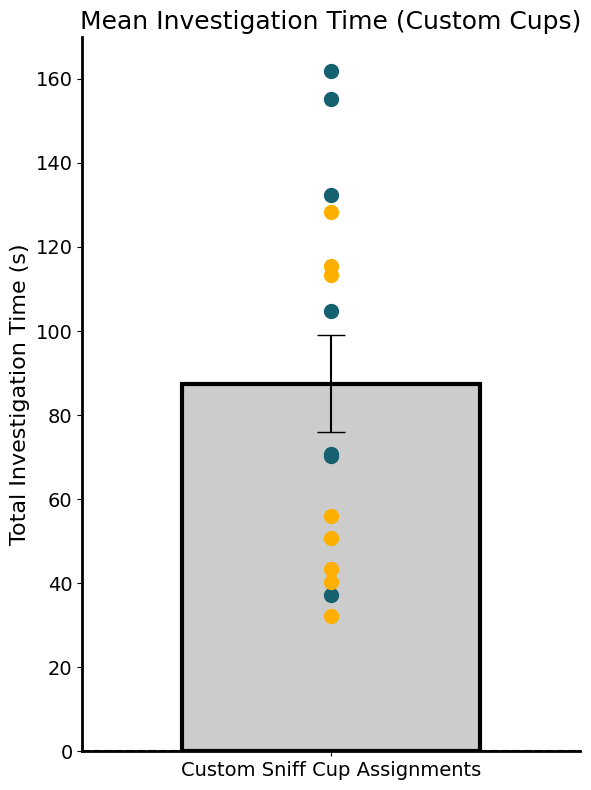

In [39]:
# Run this before plotting
fix_behavior_data_for_experiment(experiment, csv_base_path)

# Now all experiment.trials[...].behaviors are valid — plot will work!
plot_custom_sniff_cup_assignments(experiment)

### With colors

In [46]:
def plot_grouped_sniff_cup_assignments(experiment, 
                                       bar_color='#cccccc', 
                                       color_nn_pp="red", 
                                       color_n_p="blue", 
                                       figsize=(10, 8)):
    """
    Groups subjects by prefix:
      - nn/pp subjects → one color
      - n/p subjects → another color
    Plots their assigned sniff cup investigation times with a legend.
    """

    # --- Hardcoded sniff cup assignments ---
    subject_to_behavior = {
        "N1": "sniff cup 3", "P1": "sniff cup 4", "N2": "sniff cup 1", "P3": "sniff cup 2",
        "N3": "sniff cup 2", "P2": "sniff cup 1", "N4": "sniff cup 4", "P4": "sniff cup 3",
        "N5": "sniff cup 3", "P5": "sniff cup 4", "N6": "sniff cup 1", "P7": "sniff cup 2",
        "P6": "sniff cup 1", "N7": "sniff cup 2", "P8": "sniff cup 3", "Nn1": "sniff cup 4",
        "Nn2": "sniff cup 1", "Nn5": "sniff cup 2", "Nn6": "sniff cup 3", "Pp1": "sniff cup 4",
        "Pp2": "sniff cup 1", "Pp5": "sniff cup 2", "Pp6": "sniff cup 3", "Pp3": "sniff cup 2",
        "Pp4": "sniff cup 3", "Pp7": "sniff cup 4", "Pp8": "sniff cup 1", "Nn3": "sniff cup 2",
        "Nn4": "sniff cup 3", "Nn7": "sniff cup 4", "Nn8": "sniff cup 1"
    }

    subject_data = []
    total_trials = len(experiment.trials)
    valid_trials = 0
    skipped_empty = 0
    skipped_unmatched = 0
    skipped_no_behavior = 0

    for trial_name, trial in experiment.trials.items():
        if hasattr(trial, 'behaviors') and not trial.behaviors.empty:
            df = trial.behaviors.copy()

            # Match trial to subject key
            matched_key = None
            for key in subject_to_behavior:
                if trial_name.lower().startswith(key.lower()):
                    matched_key = key
                    break

            if not matched_key:
                skipped_unmatched += 1
                continue

            target_behavior = subject_to_behavior[matched_key].lower()

            # Filter for the assigned behavior
            behavior_df = df[df["Behavior"].str.lower() == target_behavior]
            if behavior_df.empty:
                skipped_no_behavior += 1
                continue

            total_time = behavior_df["Duration (s)"].sum()

            # Determine color group
            if matched_key.lower().startswith(("nn", "pp")):
                color = color_nn_pp
                group_label = "nn / pp"
            else:
                color = color_n_p
                group_label = "n / p"

            subject_data.append({
                "Trial": trial_name,
                "Group": group_label,
                "Total Investigation Time": total_time,
                "Color": color
            })
            valid_trials += 1
        else:
            skipped_empty += 1

    print(f"\nTotal trials: {total_trials}")
    print(f"Valid trials with matched behavior: {valid_trials}")
    print(f"Skipped (empty): {skipped_empty}, Skipped (no match): {skipped_unmatched}, Skipped (no behavior data): {skipped_no_behavior}")

    if not subject_data:
        print("No valid investigation data found for custom assignments.")
        return

    data_df = pd.DataFrame(subject_data)

    num_subjects = len(data_df)
    print(f"Number of mice (data points) plotted: {num_subjects}")

    # --- Plot ---
    mean_time = data_df["Total Investigation Time"].mean()
    sem_time = data_df["Total Investigation Time"].sem()

    fig, ax = plt.subplots(figsize=figsize)

    # Plot mean bar
    ax.bar(0, mean_time, yerr=sem_time, capsize=10, color=bar_color,
           edgecolor='black', linewidth=3, width=0.6)

    # Plot individual data points by group color
    for _, row in data_df.iterrows():
        ax.plot(0, row["Total Investigation Time"], 'o', color=row["Color"], markersize=10)

    # Labels & formatting
    ax.set_xticks([0])
    ax.set_xticklabels(["Custom Sniff Cup Assignments"], fontsize=14)
    ax.set_ylabel("Total Investigation Time (s)", fontsize=16)
    ax.set_title("Mean Investigation Time (Grouped Colors)", fontsize=18)
    ax.set_xlim(-0.5, 0.5)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1.5)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params(axis='y', labelsize=14)

    # Legend for color groups
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_n_p,
                   markersize=10, label="Cohort 1 + 2"),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_nn_pp,
                   markersize=10, label="Cohort 3")
    ]
    ax.legend(handles=legend_elements, title="Groups", loc='upper left', fontsize=10, title_fontsize=12)

    plt.tight_layout()
    plt.show()



Total trials: 31
Valid trials with matched behavior: 31
Skipped (empty): 0, Skipped (no match): 0, Skipped (no behavior data): 0
Number of mice (data points) plotted: 31


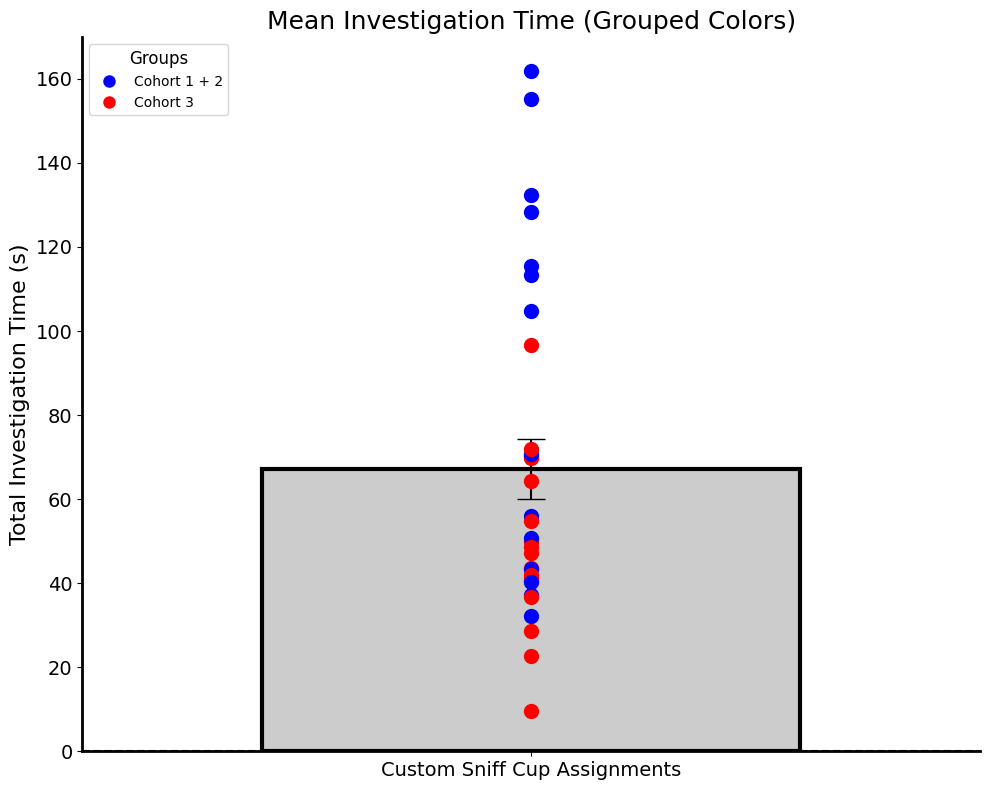

In [47]:
plot_grouped_sniff_cup_assignments(experiment)

In [51]:
def plot_grouped_sniff_cup_assignments(experiment, 
                                       bar_color='#cccccc', 
                                       color_nn_pp="red", 
                                       color_n_p="blue", 
                                       figsize=(10, 8)):
    """
    Groups subjects by prefix:
      - nn/pp subjects → one color
      - n/p subjects → another color
    Plots their assigned sniff cup investigation times with a legend showing count above/below mean.
    """

    # --- Hardcoded sniff cup assignments ---
    subject_to_behavior = {
        "N1": "sniff cup 3", "P1": "sniff cup 4", "N2": "sniff cup 1", "P3": "sniff cup 2",
        "N3": "sniff cup 2", "P2": "sniff cup 1", "N4": "sniff cup 4", "P4": "sniff cup 3",
        "N5": "sniff cup 3", "P5": "sniff cup 4", "N6": "sniff cup 1", "P7": "sniff cup 2",
        "P6": "sniff cup 1", "N7": "sniff cup 2", "P8": "sniff cup 3", "Nn1": "sniff cup 4",
        "Nn2": "sniff cup 1", "Nn5": "sniff cup 2", "Nn6": "sniff cup 3", "Pp1": "sniff cup 4",
        "Pp2": "sniff cup 1", "Pp5": "sniff cup 2", "Pp6": "sniff cup 3", "Pp3": "sniff cup 2",
        "Pp4": "sniff cup 3", "Pp7": "sniff cup 4", "Pp8": "sniff cup 1", "Nn3": "sniff cup 2",
        "Nn4": "sniff cup 3", "Nn7": "sniff cup 4", "Nn8": "sniff cup 1"
    }

    subject_data = []
    total_trials = len(experiment.trials)
    valid_trials = 0
    skipped_empty = 0
    skipped_unmatched = 0
    skipped_no_behavior = 0

    for trial_name, trial in experiment.trials.items():
        if hasattr(trial, 'behaviors') and not trial.behaviors.empty:
            df = trial.behaviors.copy()

            # Match trial to subject key
            matched_key = None
            for key in subject_to_behavior:
                if trial_name.lower().startswith(key.lower()):
                    matched_key = key
                    break

            if not matched_key:
                skipped_unmatched += 1
                continue

            target_behavior = subject_to_behavior[matched_key].lower()

            # Filter for the assigned behavior
            behavior_df = df[df["Behavior"].str.lower() == target_behavior]
            if behavior_df.empty:
                skipped_no_behavior += 1
                continue

            total_time = behavior_df["Duration (s)"].sum()

            # Determine color group
            if matched_key.lower().startswith(("nn", "pp")):
                color = color_nn_pp
                group_label = "nn / pp"
            else:
                color = color_n_p
                group_label = "n / p"

            subject_data.append({
                "Trial": trial_name,
                "Group": group_label,
                "Total Investigation Time": total_time,
                "Color": color
            })
            valid_trials += 1
        else:
            skipped_empty += 1

    print(f"\nTotal trials: {total_trials}")
    print(f"Valid trials with matched behavior: {valid_trials}")
    print(f"Skipped (empty): {skipped_empty}, Skipped (no match): {skipped_unmatched}, Skipped (no behavior data): {skipped_no_behavior}")

    if not subject_data:
        print("No valid investigation data found for custom assignments.")
        return

    data_df = pd.DataFrame(subject_data)

    num_subjects = len(data_df)
    print(f"Number of mice (data points) plotted: {num_subjects}")

    # --- Compute stats ---
    mean_time = data_df["Total Investigation Time"].mean()
    sem_time = data_df["Total Investigation Time"].sem()

    # Count above and on/below the mean
    above_mean = (data_df["Total Investigation Time"] > mean_time).sum()
    below_or_equal_mean = (data_df["Total Investigation Time"] <= mean_time).sum()

    print(f"Mice ABOVE mean: {above_mean}, Mice ON/BELOW mean: {below_or_equal_mean}")

    # --- Plot ---
    fig, ax = plt.subplots(figsize=figsize)

    # Plot mean bar
    ax.bar(0, mean_time, yerr=sem_time, capsize=10, color=bar_color,
           edgecolor='black', linewidth=3, width=0.6)

    # Plot individual data points by group color
    for _, row in data_df.iterrows():
        ax.plot(0, row["Total Investigation Time"], 'o', color=row["Color"], markersize=10)

    # Labels & formatting
    ax.set_xticks([0])
    ax.set_xticklabels(["Custom Sniff Cup Assignments"], fontsize=14)
    ax.set_ylabel("Total Investigation Time (s)", fontsize=16)
    ax.set_title("Mean Investigation Time (Grouped Colors)", fontsize=18)
    ax.set_xlim(-0.5, 0.5)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1.5)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params(axis='y', labelsize=14)

    # Legend with count info
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_n_p,
                   markersize=10, label="n / p subjects"),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_nn_pp,
                   markersize=10, label="nn / pp subjects"),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black',
                   markersize=0, label=f"Above mean: {above_mean}"),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black',
                   markersize=0, label=f"On/Below mean: {below_or_equal_mean}")
    ]
    ax.legend(handles=legend_elements, title="Groups + Counts", loc='upper left', fontsize=10, title_fontsize=12)

    plt.tight_layout()
    plt.show()



Total trials: 31
Valid trials with matched behavior: 31
Skipped (empty): 0, Skipped (no match): 0, Skipped (no behavior data): 0
Number of mice (data points) plotted: 31
Mice ABOVE mean: 12, Mice ON/BELOW mean: 19


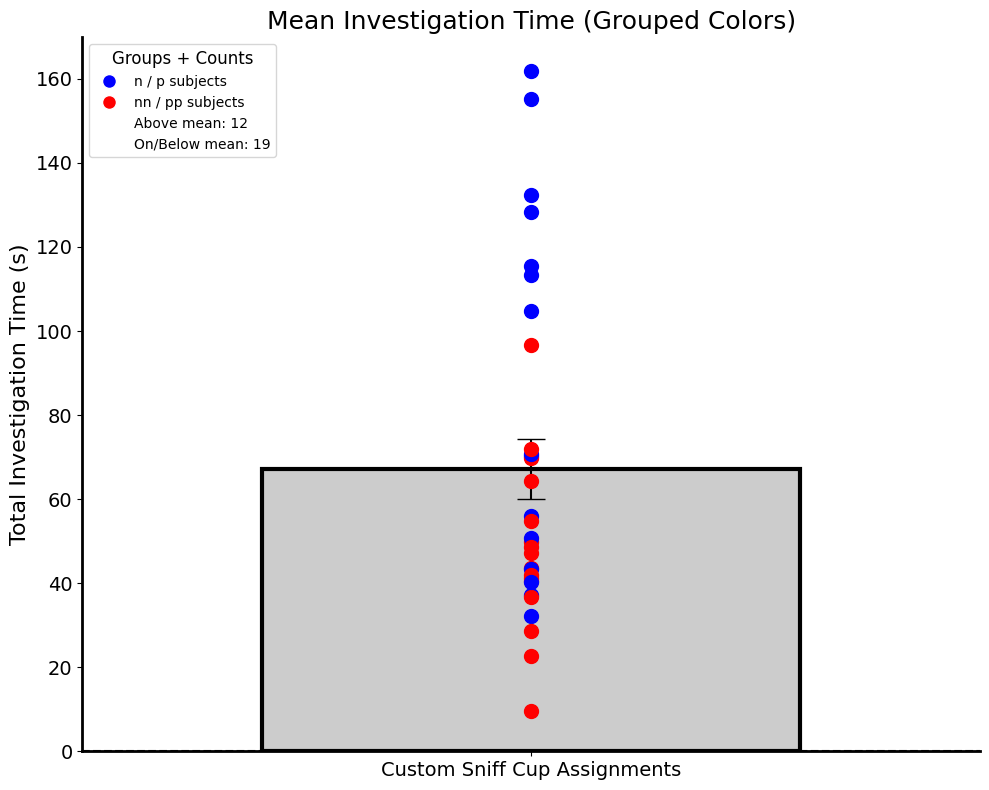

In [52]:
plot_grouped_sniff_cup_assignments(experiment)


In [41]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_custom_sniff_cup_assignments_with_legend(experiment, bar_color='#cccccc', figsize=(12, 8)):
    """
    For each subject, extracts total investigation time for a pre-assigned 'sniff cup X' behavior,
    plots individual data in a unique color per subject, and adds a legend mapping subject → color.
    """

    # --- Hardcoded sniff cup assignments ---
    subject_to_behavior = {
        "N1": "sniff cup 3",
        "P1": "sniff cup 4",
        "N2": "sniff cup 1",
        "P3": "sniff cup 2",
        "N3": "sniff cup 2",
        "P2": "sniff cup 1",
        "N4": "sniff cup 4",
        "P4": "sniff cup 3",
        "N5": "sniff cup 3",
        "P5": "sniff cup 4",
        "N6": "sniff cup 1",
        "P7": "sniff cup 2",
        "P6": "sniff cup 1",
        "N7": "sniff cup 2",
        "P8": "sniff cup 3",
        "Nn1": "sniff cup 4",
        "Nn2": "sniff cup 1",
        "Nn5": "sniff cup 2",
        "Nn6": "sniff cup 3",
        "Pp1": "sniff cup 4",
        "Pp2": "sniff cup 1",
        "Pp5": "sniff cup 2",
        "Pp6": "sniff cup 3",
        "Pp3": "sniff cup 2",
        "Pp4": "sniff cup 3",
        "Pp7": "sniff cup 4",
        "Pp8": "sniff cup 1",
        "Nn3": "sniff cup 2",
        "Nn4": "sniff cup 3",
        "Nn7": "sniff cup 4",
        "Nn8": "sniff cup 1"
    }

    # --- Unique color for each subject ---
    subject_colors = [
        "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b",
        "#e377c2", "#7f7f7f", "#bcbd22", "#17becf", "#393b79", "#637939",
        "#8c6d31", "#843c39", "#7b4173", "#5254a3", "#9c9ede", "#cedb9c",
        "#bd9e39", "#d6616b", "#e7969c", "#a55194", "#de9ed6", "#6b6ecf",
        "#9c9ede", "#637939", "#e7ba52", "#e7969c", "#843c39", "#8c6d31", "#7b4173"
    ]

    subject_to_color = dict(zip(subject_to_behavior.keys(), subject_colors))

    # --- Data collection ---
    subject_data = []
    total_trials = len(experiment.trials)
    valid_trials = 0
    skipped_empty = 0
    skipped_unmatched = 0
    skipped_no_behavior = 0

    for trial_name, trial in experiment.trials.items():
        if hasattr(trial, 'behaviors') and not trial.behaviors.empty:
            df = trial.behaviors.copy()

            # Match trial to subject key
            matched_key = None
            for key in subject_to_behavior:
                if trial_name.lower().startswith(key.lower()):
                    matched_key = key
                    break

            if not matched_key:
                print(f"Skipped trial '{trial_name}' — no subject assignment match.")
                skipped_unmatched += 1
                continue

            target_behavior = subject_to_behavior[matched_key].lower()

            # Filter for the assigned behavior
            behavior_df = df[df["Behavior"].str.lower() == target_behavior]
            if behavior_df.empty:
                print(f"Skipped trial '{trial_name}' — no data for '{target_behavior}'.")
                skipped_no_behavior += 1
                continue

            total_time = behavior_df["Duration (s)"].sum()

            subject_data.append({
                "Trial": trial_name,
                "Subject Key": matched_key,
                "Total Investigation Time": total_time,
                "Color": subject_to_color[matched_key]
            })
            valid_trials += 1
        else:
            skipped_empty += 1
            print(f"Skipped trial '{trial_name}' — empty behaviors DataFrame.")

    print(f"\nTotal trials: {total_trials}")
    print(f"Valid trials with matched behavior: {valid_trials}")
    print(f"Skipped (empty): {skipped_empty}, Skipped (no match): {skipped_unmatched}, Skipped (no behavior data): {skipped_no_behavior}")

    if not subject_data:
        print("No valid investigation data found for custom assignments.")
        return

    data_df = pd.DataFrame(subject_data)

    num_subjects = len(data_df)
    print(f"Number of mice (data points) plotted: {num_subjects}")

    # --- Plot ---
    mean_time = data_df["Total Investigation Time"].mean()
    sem_time = data_df["Total Investigation Time"].sem()

    fig, ax = plt.subplots(figsize=figsize)

    # Plot mean bar
    ax.bar(0, mean_time, yerr=sem_time, capsize=10, color=bar_color,
           edgecolor='black', linewidth=3, width=0.6)

    # Plot individual data points with unique colors
    for _, row in data_df.iterrows():
        ax.plot(0, row["Total Investigation Time"], 'o', color=row["Color"], markersize=10)

    # Set labels and title
    ax.set_xticks([0])
    ax.set_xticklabels(["Custom Sniff Cup Assignments"], fontsize=14)
    ax.set_ylabel("Total Investigation Time (s)", fontsize=16)
    ax.set_title("Mean Investigation Time per Subject (Custom Cups)", fontsize=18)
    ax.set_xlim(-0.5, 0.5)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1.5)

    # Beautify plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params(axis='y', labelsize=14)

    # --- Legend ---
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=subject_to_color[key],
                   markersize=10, label=key)
        for key in subject_to_behavior.keys()
    ]

    ax.legend(handles=legend_elements, title="Subjects", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12, borderaxespad=0.)

    plt.tight_layout()
    plt.show()



Total trials: 31
Valid trials with matched behavior: 31
Skipped (empty): 0, Skipped (no match): 0, Skipped (no behavior data): 0
Number of mice (data points) plotted: 31


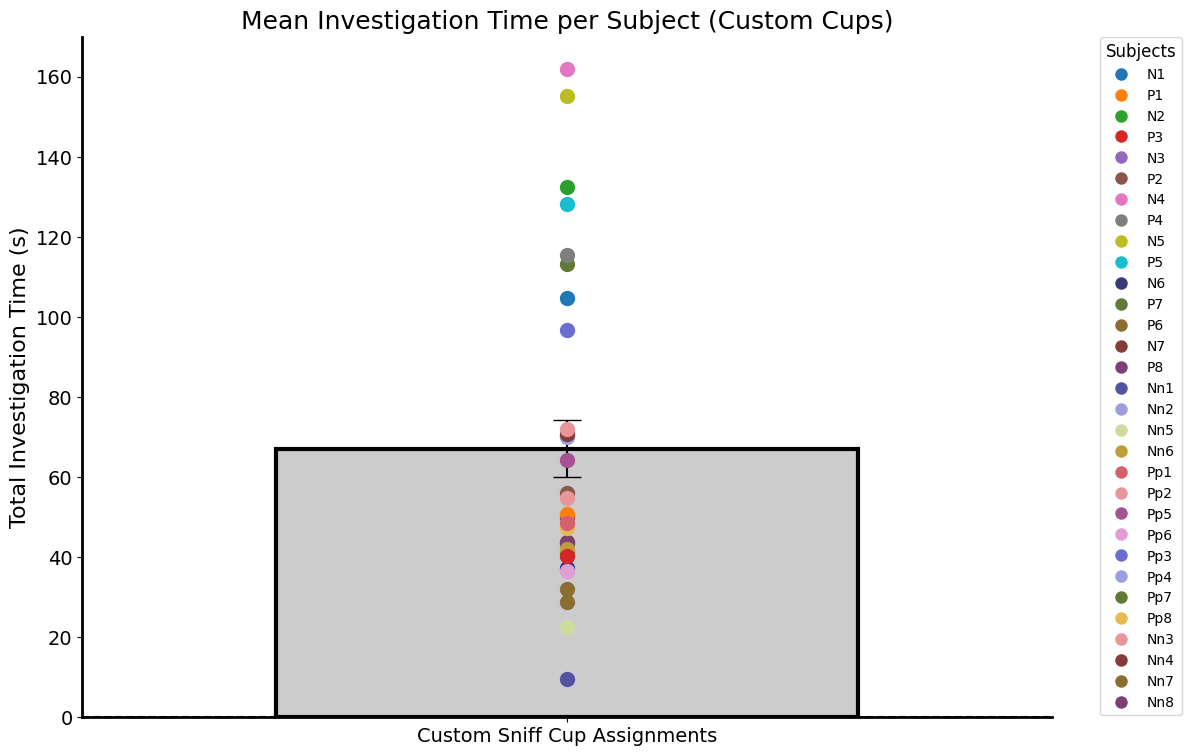

In [ ]:
plot_custom_sniff_cup_assignments_with_legend(experiment)

In [12]:
import os

csv_base_path = r"/Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/C1_2_3_Social_Pref/all_csvs"

# Example skipped trial name
trial_name = 'nn2-250117-085631'
csv_filename = trial_name + '.csv'
csv_file_path = os.path.join(csv_base_path, csv_filename)

print(f"Looking for CSV: {csv_file_path}")
print("File exists:", os.path.exists(csv_file_path))

if os.path.exists(csv_file_path):
    df = pd.read_csv(csv_file_path)
    print(df.head())


Looking for CSV: /Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/C1_2_3_Social_Pref/all_csvs/nn2-250117-085631.csv
File exists: True
      Observation id         Observation date  Description Observation type  \
0  nn2-250117-085631  2025-02-18 22:56:27.810          NaN       Media file   
1  nn2-250117-085631  2025-02-18 22:56:27.810          NaN       Media file   
2  nn2-250117-085631  2025-02-18 22:56:27.810          NaN       Media file   
3  nn2-250117-085631  2025-02-18 22:56:27.810          NaN       Media file   
4  nn2-250117-085631  2025-02-18 22:56:27.810          NaN       Media file   

                                              Source  Time offset (s)  \
0  player #1:C:/Users/aquar/Downloads/1_17_25_Soc...              0.0   
1  player #1:C:/Users/aquar/Downloads/1_17_25_Soc...              0.0   
2  player #1:C:/Users/aquar/Downloads/1_17_25_Soc...              0.0   
3  player #1:C:/Users/aquar/Downloads/1_17_25_Soc...              0.0   
4  p

In [7]:
for trial_name, trial in experiment.trials.items():
    print(f"\nTrial: {trial_name}")
    if hasattr(trial, 'behaviors'):
        print(trial.behaviors.head())  # Show first few rows
        print("Columns:", trial.behaviors.columns.tolist())
    else:
        print("No behaviors attribute")



Trial: p5-240826-091418
        Bout     Behavior  Event_Start  Event_End  Duration (s)
0  Subject-1  sniff cup 1        211.9      218.2           6.3
1  Subject-1  sniff cup 1        356.4      364.7           8.3
2  Subject-1  sniff cup 1        433.2      444.1          10.9
3  Subject-1  sniff cup 1        472.9      477.0           4.1
4  Subject-1  sniff cup 1        581.8      582.6           0.8
Columns: ['Bout', 'Behavior', 'Event_Start', 'Event_End', 'Duration (s)']

Trial: nn2-250117-085631
Empty DataFrame
Columns: []
Index: []
Columns: []

Trial: p2-240523-081105
        Bout     Behavior  Event_Start  Event_End  Duration (s)
0  Subject-1  sniff cup 1      197.733    199.867         2.134
1  Subject-1  sniff cup 1      230.733    231.733         1.000
2  Subject-1  sniff cup 1      239.800    244.200         4.400
3  Subject-1  sniff cup 1      298.000    302.200         4.200
4  Subject-1  sniff cup 1      303.267    304.533         1.266
Columns: ['Bout', 'Behavior', 'E

In [8]:
def get_trial_dataframes(experiment):
    """
    Given an Experiment object, return a list of DataFrames,
    where each DataFrame corresponds to the .behaviors of each trial.
    """
    # Extract all trial IDs from the experiment
    trial_ids = list(experiment.trials.keys())

    # Retrieve a DataFrame of behaviors for each trial
    trial_dataframes = [experiment.trials[tid].behaviors for tid in trial_ids]

    return trial_dataframes

def process_investigation_data(df, 
                               behavior_name='Investigation', 
                               gap_threshold=1.0, 
                               min_duration=0.5,
                               desired_bouts=None,
                               agg_func='sum'):
    """
    Merge consecutive Investigation events within 'gap_threshold' seconds,
    remove events shorter than 'min_duration', then group/pivot by Subject & Bout.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must have columns: [Subject, Behavior, Bout, Event_Start, Event_End, Duration (s)]
    behavior_name : str
        Which behavior to combine/filter (default 'Investigation').
    gap_threshold : float
        Max gap (in seconds) to consider consecutive events mergeable.
    min_duration : float
        Minimum duration below which events are removed.
    desired_bouts : list or None
        Which bouts to keep (if None, keep all).
    agg_func : {'sum', 'mean'}
        How to combine the durations in the final group step.
        
    Returns
    -------
    pivot_df : pd.DataFrame
        Pivoted DataFrame of aggregated durations by Subject × Bout.
    """
    
    #--- 1) Keep only rows matching the specified behavior ---
    df = df[df["Behavior"] == behavior_name].copy()
    
    #--- 2) Sort so consecutive events are truly consecutive by subject & start time ---
    df.sort_values(["Subject", "Event_Start"], inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    #--- 3) Identify which rows should *not* merge with their predecessor ---
    df["new_block"] = (
        (df["Subject"] != df["Subject"].shift(1)) |
        (df["Event_Start"] - df["Event_End"].shift(1) > gap_threshold)
    )
    df["group_id"] = df["new_block"].cumsum()
    
    #--- 4) Merge consecutive events in each group_id ---
    merged = (
        df.groupby("group_id", as_index=False)
          .agg({
              "Subject":      "first",
              "Behavior":     "first",
              "Bout":         "first",  # Uses the first bout label in the block
              "Event_Start":  "min",
              "Event_End":    "max",
              "Duration (s)": "sum"
          })
    )
    
    #--- 5) Remove events shorter than min_duration ---
    merged = merged[merged["Duration (s)"] >= min_duration].copy()
    
    #--- 6) Filter by desired bouts (if provided) ---
    if desired_bouts is not None:
        merged = merged[merged["Bout"].isin(desired_bouts)]
    
    #--- 7) Group by Subject & Bout with either sum or mean, then pivot ---
    if agg_func == 'sum':
        grouped_df = merged.groupby(["Subject", "Bout"], as_index=False)["Duration (s)"].sum()
    elif agg_func == 'mean':
        grouped_df = merged.groupby(["Subject", "Bout"], as_index=False)["Duration (s)"].mean()
    else:
        raise ValueError("agg_func must be either 'sum' or 'mean'")
    
    pivot_df = (
        grouped_df
        .pivot(index="Subject", columns="Bout", values="Duration (s)")
        .fillna(0)
    )
    
    return pivot_df

def create_subject_summary_df(dfs):
    """
    Takes in a list of DataFrames (each CSV is one subject),
    and assigns a unique Subject ID (1 to N) to each DataFrame.
    
    For each subject:
      - Total Investigation Time = sum of "Duration (s)"
      - Average Bout Duration = total_investigation_time / number_of_bouts
    
    Returns a single DataFrame with columns:
      ['Bout', 'Subject', 'Behavior', 'Duration (s)',
       'Total Investigation Time', 'Average Bout Duration']
    """
    processed_list = []
    subject_id = 1
    
    for df in dfs:
        temp_df = df.copy()
        
        # Assign this entire CSV to one Subject
        temp_df["Subject"] = subject_id
        
        # Calculate sums and average for this subject
        total_invest_time = temp_df["Duration (s)"].sum()
        num_bouts = temp_df["Bout"].nunique()  # how many unique bouts in this CSV
        avg_bout_dur = total_invest_time / num_bouts if num_bouts else 0
        
        # Attach these values to every row
        temp_df["Total Investigation Time"] = total_invest_time
        temp_df["Average Bout Duration"] = avg_bout_dur
        
        processed_list.append(temp_df)
        subject_id += 1  # next CSV -> next Subject
    
    # Concatenate all into a single DataFrame
    final_df = pd.concat(processed_list, ignore_index=True)
    return final_df


In [9]:
desired_bouts = ["sniff cup 1", "sniff cup 2", "sniff cup 3", "sniff cup 4"]

dfs = get_trial_dataframes(experiment)
ready_df = create_subject_summary_df(dfs)

pivot = process_investigation_data(
    ready_df,
    behavior_name="Investigation",   # or "Approach" if you prefer
    gap_threshold=0.3,
    min_duration=.00000000000000001,
    desired_bouts=desired_bouts,
    agg_func='sum'
)

KeyError: 'Duration (s)'

## Behavior

In [ ]:
def get_trial_dataframes(experiment):
    """
    Given an Experiment object, return a list of DataFrames,
    where each DataFrame corresponds to the .behaviors of each trial.
    """
    # Extract all trial IDs from the experiment
    trial_ids = list(experiment.trials.keys())
    print(trial_ids)

    # Retrieve a DataFrame of behaviors for each trial
    trial_dataframes = [experiment.trials[tid].behaviors for tid in trial_ids]
    print(trial_dataframes)

    return trial_dataframes

def process_investigation_data(df, 
                               behavior_name='Investigation', 
                               gap_threshold=1.0, 
                               min_duration=0.5,
                               desired_bouts=None,
                               agg_func='sum'):
    """
    Merge consecutive Investigation events within 'gap_threshold' seconds,
    remove events shorter than 'min_duration', then group/pivot by Subject & Bout.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must have columns: [Subject, Behavior, Bout, Event_Start, Event_End, Duration (s)]
    behavior_name : str
        Which behavior to combine/filter (default 'Investigation').
    gap_threshold : float
        Max gap (in seconds) to consider consecutive events mergeable.
    min_duration : float
        Minimum duration below which events are removed.
    desired_bouts : list or None
        Which bouts to keep (if None, keep all).
    agg_func : {'sum', 'mean'}
        How to combine the durations in the final group step.
        
    Returns
    -------
    pivot_df : pd.DataFrame
        Pivoted DataFrame of aggregated durations by Subject × Bout.
    """
    
    #--- 1) Keep only rows matching the specified behavior ---
    df = df[df["Behavior"] == behavior_name].copy()
    
    #--- 2) Sort so consecutive events are truly consecutive by subject & start time ---
    df.sort_values(["Subject", "Event_Start"], inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    #--- 3) Identify which rows should *not* merge with their predecessor ---
    df["new_block"] = (
        (df["Subject"] != df["Subject"].shift(1)) |
        (df["Event_Start"] - df["Event_End"].shift(1) > gap_threshold)
    )
    df["group_id"] = df["new_block"].cumsum()
    
    #--- 4) Merge consecutive events in each group_id ---
    merged = (
        df.groupby("group_id", as_index=False)
          .agg({
              "Subject":      "first",
              "Behavior":     "first",
              "Bout":         "first",  # Uses the first bout label in the block
              "Event_Start":  "min",
              "Event_End":    "max",
              "Duration (s)": "sum"
          })
    )
    
    #--- 5) Remove events shorter than min_duration ---
    merged = merged[merged["Duration (s)"] >= min_duration].copy()
    
    #--- 6) Filter by desired bouts (if provided) ---
    if desired_bouts is not None:
        merged = merged[merged["Bout"].isin(desired_bouts)]
    
    #--- 7) Group by Subject & Bout with either sum or mean, then pivot ---
    if agg_func == 'sum':
        grouped_df = merged.groupby(["Subject", "Bout"], as_index=False)["Duration (s)"].sum()
    elif agg_func == 'mean':
        grouped_df = merged.groupby(["Subject", "Bout"], as_index=False)["Duration (s)"].mean()
    else:
        raise ValueError("agg_func must be either 'sum' or 'mean'")
    
    pivot_df = (
        grouped_df
        .pivot(index="Subject", columns="Bout", values="Duration (s)")
        .fillna(0)
    )
    
    return pivot_df

def create_subject_summary_df(dfs):
    """
    Takes in a list of DataFrames (each CSV is one subject),
    and assigns a unique Subject ID (1 to N) to each DataFrame.
    
    For each subject:
      - Total Investigation Time = sum of "Duration (s)"
      - Average Bout Duration = total_investigation_time / number_of_bouts
    
    Returns a single DataFrame with columns:
      ['Bout', 'Subject', 'Behavior', 'Duration (s)',
       'Total Investigation Time', 'Average Bout Duration']
    """
    processed_list = []
    subject_id = 1
    
    for df in dfs:
        temp_df = df.copy()
        
        # Assign this entire CSV to one Subject
        temp_df["Subject"] = subject_id
        
        # Calculate sums and average for this subject
        total_invest_time = temp_df["Duration (s)"].sum()
        num_bouts = temp_df["Bout"].nunique()  # how many unique bouts in this CSV
        avg_bout_dur = total_invest_time / num_bouts if num_bouts else 0
        
        # Attach these values to every row
        temp_df["Total Investigation Time"] = total_invest_time
        temp_df["Average Bout Duration"] = avg_bout_dur
        
        processed_list.append(temp_df)
        subject_id += 1  # next CSV -> next Subject
    
    # Concatenate all into a single DataFrame
    final_df = pd.concat(processed_list, ignore_index=True)
    return final_df


In [ ]:
desired_bouts = ['s1-1', 's1-2', 's1-3', 's1-4', 's1-5', 's2-1']

dfs = get_trial_dataframes(experiment)
ready_df = create_subject_summary_df(dfs)

pivot = process_investigation_data(
    ready_df,
    behavior_name="Investigation",   # or "Approach" if you prefer
    gap_threshold=0.3,
    min_duration=.00000000000000001,
    desired_bouts=desired_bouts,
    agg_func='mean'
)

['p5-240826-091418', 'nn2-250117-085631', 'p2-240523-081105', 'nn4-250118-094351', 'n6-240826-094701', 'nn1-250117-081652', 'pp7-250118-075659', 'pp3-250118-064713', 'p8-240827-075823', 'nn8-250118-105443', 'n3-240523-073132', 'p1-240522-080200', 'n5-240826-083822', 'n4-240523-084829', 'p6-240827-065303', 'pp5-250117-121543', 'pp4-250118-072201', 'nn7-250118-101917', 'pp8-250118-083250', 'nn6-250117-101903', 'p7-240826-102402', 'pp6-250117-124823', 'n7-240827-072608', 'n2-240522-084131', 'p3-240522-092431', 'nn3-250118-090940', 'n1-240522-072114', 'nn5-250117-093631', 'p4-240523-092600', 'pp1-250117-110456', 'pp2-250117-113909']
[         Bout     Behavior  Event_Start  Event_End  Duration (s)
0   Subject-1  sniff cup 1        211.9      218.2           6.3
1   Subject-1  sniff cup 1        356.4      364.7           8.3
2   Subject-1  sniff cup 1        433.2      444.1          10.9
3   Subject-1  sniff cup 1        472.9      477.0           4.1
4   Subject-1  sniff cup 1        581

KeyError: 'Duration (s)'

In [ ]:
# cohort 3 nac
nn1 = experiment.trials['nn1-250117-081652']
nn2 = experiment.trials['nn2-250117-085631']
nn3 = experiment.trials['nn3-250118-090940']
nn4 = experiment.trials['nn4-250118-094351']
nn5 = experiment.trials['nn5-250117-093631']
nn6 = experiment.trials['nn6-250117-101903']
nn7 = experiment.trials['nn7-250118-101917']
nn8 = experiment.trials['nn8-250118-105443']
'''
# cohort 3 mpfc
pp1 = experiment.trials['pp1-250117-110456']
pp2 = experiment.trials['pp2-250117-113909']
pp3 = experiment.trials['pp3-250118-064713']
pp4 = experiment.trials['pp4-250118-072201']
pp5 = experiment.trials['pp5-250117-121543']
pp6 = experiment.trials['pp6-250117-124823']
pp7 = experiment.trials['pp7-250118-075659']
pp8 = experiment.trials['pp8-250118-083250']
'''
df1 = nn1.behaviors
df2 = nn2.behaviors
df3 = nn3.behaviors
df4 = nn4.behaviors
df5 = nn5.behaviors
df6 = nn6.behaviors
df7 = nn7.behaviors
df8 = nn8.behaviors
'''
df9 = pp1.behaviors
df10 = pp2.behaviors
df11 = pp3.behaviors
df12 = pp4.behaviors
df13 = pp5.behaviors
df14 = pp6.behaviors
df15 = pp7.behaviors
df16 = pp8.behaviors
'''

'\ndf9 = pp1.behaviors\ndf10 = pp2.behaviors\ndf11 = pp3.behaviors\ndf12 = pp4.behaviors\ndf13 = pp5.behaviors\ndf14 = pp6.behaviors\ndf15 = pp7.behaviors\ndf16 = pp8.behaviors\n'

In [ ]:
def create_subject_summary_df(dfs):
    """
    Takes in a list of DataFrames (each CSV is one subject),
    and assigns a unique Subject ID (1 to N) to each DataFrame.
    
    For each subject:
      - Total Investigation Time = sum of "Duration (s)"
      - Average Bout Duration = total_investigation_time / number_of_bouts
    
    Returns a single DataFrame with columns:
      ['Bout', 'Subject', 'Behavior', 'Duration (s)',
       'Total Investigation Time', 'Average Bout Duration']
    """
    processed_list = []
    subject_id = 1
    
    for df in dfs:
        temp_df = df.copy()
        
        # Assign this entire CSV to one Subject
        temp_df["Subject"] = subject_id
        
        # Calculate sums and average for this subject
        total_invest_time = temp_df["Duration (s)"].sum()
        num_bouts = temp_df["Bout"].nunique()  # how many unique bouts in this CSV
        avg_bout_dur = total_invest_time / num_bouts if num_bouts else 0
        
        # Attach these values to every row
        temp_df["Total Investigation Time"] = total_invest_time
        temp_df["Average Bout Duration"] = avg_bout_dur
        
        processed_list.append(temp_df)
        subject_id += 1  # next CSV -> next Subject
    
    # Concatenate all into a single DataFrame
    final_df = pd.concat(processed_list, ignore_index=True)
    return final_df


In [ ]:
#  Create a list of the DataFrames
trials = [df1, df2, df3, df4, df5, df6, df7, df8]

# Create one combined summary DataFrame (7 subjects total)
summary_df = create_subject_summary_df(trials)

# --- Behavior Processing for Each Subject ---
for nn in [nn1, nn2, nn3, nn4, nn5, nn6, nn7, nn8]:
    # Merge consecutive Investigation events that occur within 1 second.
    nn.combine_consecutive_behaviors(behavior_name='Investigation', bout_time_threshold=1)
    # Remove Investigation events shorter than 0.5 seconds (or adjust as needed).
    nn.remove_short_behaviors(behavior_name='Investigation', min_duration=0.5)

KeyError: 'Duration (s)'